<a href="https://colab.research.google.com/github/anmolk007/Diagonosis-of-Pneumonia-from-Chest-X-Rays-using-Deep-learning/blob/main/Final_Pneumonia_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [3]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk(r'chest_xray/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
chest_xray/chest_xray/train/PNEUMONIA/person525_bacteria_2216.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person292_virus_599.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person298_bacteria_1411.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1648_bacteria_4376.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1266_bacteria_3224.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1315_bacteria_3322.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1445_bacteria_3734.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person936_virus_1598.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1411_bacteria_3602.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person550_virus_1090.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1082_bacteria_3022.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1241_bacteria_3197.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person596_bacteria_2443.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person1089_virus_1808.jpeg
chest_xray/chest

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

**Data Pre-Processing**

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                ycrcb_img = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2YCrCb)
                # equalize the histogram of the Y channel
                ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
                # convert back to RGB color-space from YCrCb
                equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
                data.append([equalized_img, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_training_data(r'chest_xray/chest_xray/train')
test = get_training_data(r'chest_xray/chest_xray/test')
val = get_training_data(r'chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [7]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)

Pneumonia: 3875
Normal: 1341


PNEUMONIA


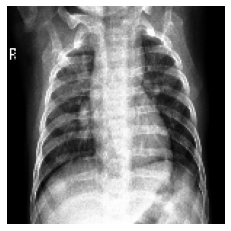

In [8]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [9]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)

# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)

train_ratio = 0.75
test_ratio = 0.10
validation_ratio = 0.15

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

**Data Augmentation**

In [10]:
# good for balancing out disproportions in the dataset 
train_datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

train_datagen.fit(X_train)

**Model Building**

In [11]:
from tensorflow.keras.applications import VGG19

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['acc']
    )
    return model

vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(vgg19 ,lr = 1e-4)
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                         

In [12]:
# Fit Model
BATCH_SIZE = 32
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE),
    steps_per_epoch= len(X_train)/BATCH_SIZE,
    epochs= 15,
    validation_data=(X_val, y_val),
    validation_steps= len(X_val)/BATCH_SIZE
)

Epoch 1/15
137/137 [==============================] - 58s 301ms/step - loss: 0.7986 - acc: 0.7243 - val_loss: 0.5561 - val_acc: 0.7335
Epoch 2/15
137/137 [==============================] - 40s 289ms/step - loss: 0.5830 - acc: 0.7275 - val_loss: 0.6509 - val_acc: 0.7335
Epoch 3/15
137/137 [==============================] - 40s 292ms/step - loss: 0.6065 - acc: 0.7275 - val_loss: 0.5798 - val_acc: 0.7335
Epoch 4/15
137/137 [==============================] - 40s 288ms/step - loss: 0.5886 - acc: 0.7275 - val_loss: 0.5800 - val_acc: 0.7335
Epoch 5/15
137/137 [==============================] - 40s 294ms/step - loss: 0.5850 - acc: 0.7275 - val_loss: 0.5801 - val_acc: 0.7335
Epoch 6/15
137/137 [==============================] - 40s 289ms/step - loss: 0.5860 - acc: 0.7275 - val_loss: 0.5800 - val_acc: 0.7335
Epoch 7/15
137/137 [==============================] - 40s 289ms/step - loss: 0.5885 - acc: 0.7275 - val_loss: 0.5798 - val_acc: 0.7335
Epoch 8/15
137/137 [==============================] - 4

In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 5s 270ms/step - loss: 0.1267 - acc: 0.9556


[0.12669499218463898, 0.9556313753128052]

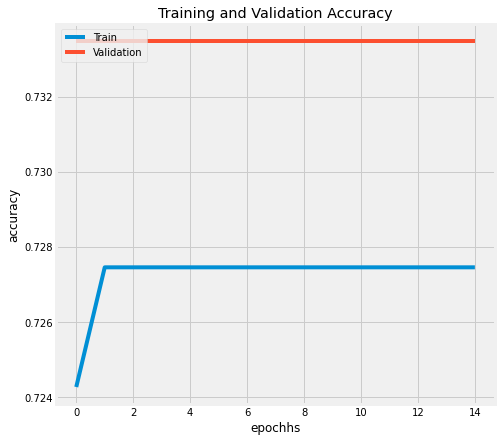

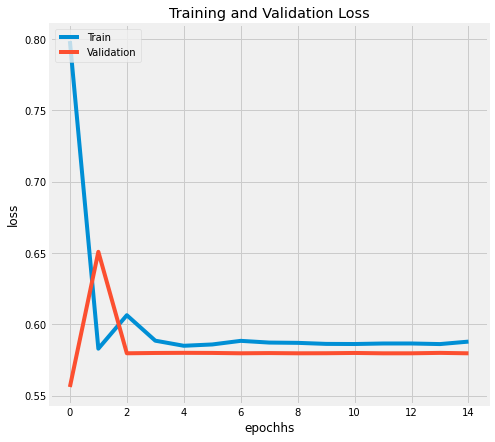

In [13]:
plt.figure(figsize=(7, 7))
plt.plot(history.epoch, history.history['acc'],label='Train')
plt.plot(history.epoch, history.history['val_acc'],label='Validation')
plt.title('Training and Validation Accuracy')
plt.legend( loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epochhs')
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(history.epoch, history.history['loss'],label='Train')
plt.plot(history.epoch, history.history['val_loss'],label='Validation')
plt.title('Training and Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('loss')
plt.xlabel('epochhs')
plt.show()


In [14]:
pred = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, pred)
fpr, tpr, thresholds2 = roc_curve(y_test, pred)

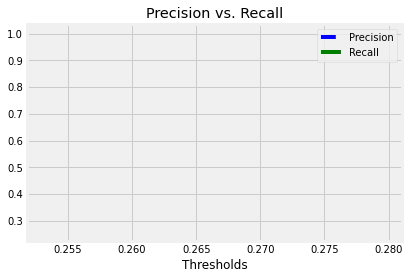

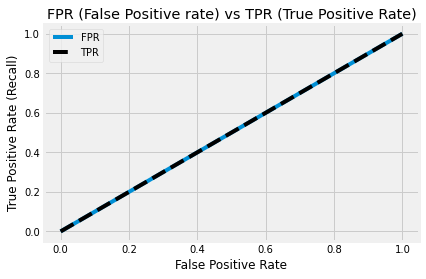

In [15]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(['FPR', 'TPR'], loc='best')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)



In [16]:
predictions = model.predict(X_test)
# predictions = predictions.reshape(1,-1)[0]
# predictions[:30]

In [17]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

IndexError: ignored

In [18]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y_test, binary_predictions,output_dict= True))

ValueError: ignored

[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

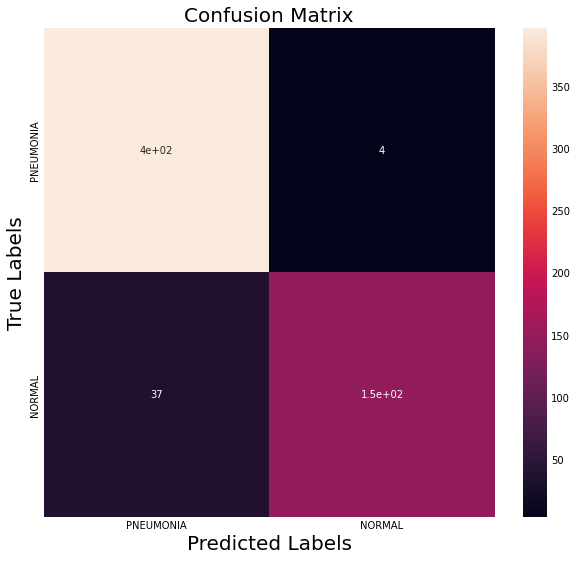

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [ ]:
model.save('pneumonia_detection_vgg19_ai_version_2.h5')

In [ ]:
import pickle

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))